In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl
import NeatMS as ntms

def makePRCPlot(pred,true,noSkill=True,label=""):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label=label + " prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)

def makeROCPlot(pred,true,label="",noSkill=True):

    fpr, tpr, threshs = met.roc_curve(true, pred)

    auc = np.round(met.auc(fpr, tpr), 4)

    plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    if noSkill:
        plt.plot([0, 1.0],[0,1.0],label="NSL")
    plt.legend()
    return auc


In [4]:
datadir = "D:/PeakDetective/data/covid_plasma/"
resolution = 60
window = 1.0
rawDataDir = datadir + "tmp/"
ms1ppm = 25.5
cutoff=0.9

In [5]:
det = detection_helper.PeakList()
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
peakList = pd.DataFrame(det.peakList)
peakList

,mz,rt,rt_start,rt_end,B1_NIST1950_1_6540.mzML,B1_NIST1950_2_6540.mzML,B1_NIST1950_3_6540.mzML
FT0001,52.995274,5.074017,5.057352,5.090650,7.850117e+03,6.526800e+03,2.891458e+05
FT0002,54.977012,5.074017,5.073996,5.074017,1.532210e+05,1.210493e+05,1.215186e+05
FT0003,55.018832,6.038233,6.038233,6.038233,6.447720e+03,9.208602e+03,7.405622e+03
FT0004,56.995900,13.086900,13.070283,13.103534,6.127502e+06,5.300639e+06,5.151324e+06
FT0005,57.034581,1.590991,1.566317,1.615666,3.627522e+04,2.545522e+04,3.088248e+04
...,...,...,...,...,...,...,...
FT4184,1612.974722,2.214650,2.214650,2.214650,1.910637e+04,1.483741e+05,1.705465e+04
FT4185,1612.976154,14.982067,14.982067,14.982067,1.358256e+04,1.228282e+04,1.231674e+04
FT4186,1613.978101,2.214650,2.214650,2.214650,3.174946e+03,5.177959e+04,2.920245e+03
FT4187,1613.977307,14.982067,14.982067,14.982067,2.855932e+04,4.999942e+04,2.388595e+04


In [6]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


In [7]:
integ = PeakDetective.PeakDetective(numCores = 15,resolution=resolution)

In [8]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [9]:
neatMSPeakList = pd.read_csv(datadir + "xcms_peak_list.csv",sep="\t",index_col=0)
neatMSPeakList["feature_id"] = neatMSPeakList.index.values
neatMSPeakList["feature_id2"] = neatMSPeakList.index.values
neatMSPeakList = neatMSPeakList.melt(id_vars = ["mzmed","rtmed","rtmin","rtmax","feature_id"],
                    value_vars = [x for x in neatMSPeakList.columns.values if ".mzML" in x],
                   var_name="sample", value_name="into")
neatMSPeakList["mzmin"] = neatMSPeakList["mzmed"].values - (ms1ppm * neatMSPeakList["mzmed"].values) / 1e6
neatMSPeakList["mzmax"] = neatMSPeakList["mzmed"].values + (ms1ppm * neatMSPeakList["mzmed"].values) / 1e6
neatMSPeakList["intb"] = neatMSPeakList["into"].values
neatMSPeakList["maxo"] = neatMSPeakList["into"].values
neatMSPeakList["sn"] = [10 for _ in range(len(neatMSPeakList))]
neatMSPeakList["sample_name"] = neatMSPeakList["sample"].values
neatMSPeakList["rtmin"] = neatMSPeakList["rtmin"].values - .2 * 60
neatMSPeakList["rtmax"] = neatMSPeakList["rtmin"].values + .2 * 60
neatMSPeakList = neatMSPeakList.rename({"mzmed":"mz","rtmed":"rt"},axis=1)

neatMSPeakList.to_csv(datadir + "neatms_peak_list.csv",index=False)
neatMSPeakList


,mz,rt,rtmin,rtmax,feature_id,sample,into,mzmin,mzmax,intb,maxo,sn,sample_name
0,52.995274,304.441000,291.441101,303.441101,FT0001,B1_NIST1950_1_6540.mzML,7.850117e+03,52.993922,52.996625,7.850117e+03,7.850117e+03,10,B1_NIST1950_1_6540.mzML
1,54.977012,304.441000,292.439758,304.439758,FT0002,B1_NIST1950_1_6540.mzML,1.532210e+05,54.975611,54.978414,1.532210e+05,1.532210e+05,10,B1_NIST1950_1_6540.mzML
2,55.018832,362.294000,350.294000,362.294000,FT0003,B1_NIST1950_1_6540.mzML,6.447720e+03,55.017429,55.020235,6.447720e+03,6.447720e+03,10,B1_NIST1950_1_6540.mzML
3,56.995900,785.214000,772.216980,784.216980,FT0004,B1_NIST1950_1_6540.mzML,6.127502e+06,56.994447,56.997353,6.127502e+06,6.127502e+06,10,B1_NIST1950_1_6540.mzML
4,57.034581,95.459482,81.979000,93.979000,FT0005,B1_NIST1950_1_6540.mzML,3.627522e+04,57.033127,57.036036,3.627522e+04,3.627522e+04,10,B1_NIST1950_1_6540.mzML
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12559,1612.974722,132.879000,120.879000,132.879000,FT4184,B1_NIST1950_3_6540.mzML,1.705465e+04,1612.933591,1613.015853,1.705465e+04,1.705465e+04,10,B1_NIST1950_3_6540.mzML
12560,1612.976154,898.924000,886.924000,898.924000,FT4185,B1_NIST1950_3_6540.mzML,1.231674e+04,1612.935023,1613.017285,1.231674e+04,1.231674e+04,10,B1_NIST1950_3_6540.mzML
12561,1613.978101,132.879000,120.879000,132.879000,FT4186,B1_NIST1950_3_6540.mzML,2.920245e+03,1613.936944,1614.019257,2.920245e+03,2.920245e+03,10,B1_NIST1950_3_6540.mzML
12562,1613.977307,898.924000,886.924000,898.924000,FT4187,B1_NIST1950_3_6540.mzML,2.388595e+04,1613.936151,1614.018464,2.388595e+04,2.388595e+04,10,B1_NIST1950_3_6540.mzML


In [10]:
feature_table_path = datadir+"neatms_peak_list.csv"
input_data = 'xcms'
experiment = ntms.Experiment(rawDataDir, feature_table_path, input_data)

In [11]:
nn_handler = ntms.NN_handler(experiment,min_scan_num=0)

In [94]:
model_path = "../data/neatms/neatms_default_model.h5"
nn_handler.create_model(model = model_path)
nn_handler.get_model_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 120, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 120, 32)        832       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 60, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 60, 64)         18496     
                                                                 
 flatten_1 (Flatten)         (None, 7680)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               983168    
                                                           

In [13]:
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

126/126 [==============================] - 1s 6ms/step


In [14]:
# We create the dataframe using this function
NeatMS_output_df = experiment.export_to_dataframe()
# And display it
NeatMS_output_df

,feature ID,sample,m/z,retention time,height,area,label
0,1,B1_NIST1950_1_6540,54.977012,5.074017,153221.001212,153221.001212,Noise
1,1,B1_NIST1950_2_6540,54.977012,5.074017,121049.319269,121049.319269,Noise
2,1,B1_NIST1950_3_6540,54.977012,5.074017,121518.648674,121518.648674,Noise
3,2,B1_NIST1950_1_6540,55.018832,6.038233,6447.719840,6447.719840,Noise
4,2,B1_NIST1950_2_6540,55.018832,6.038233,9208.601970,9208.601970,Noise
...,...,...,...,...,...,...,...
12092,4186,B1_NIST1950_2_6540,1613.977307,14.982067,49999.415489,49999.415489,High_quality
12093,4186,B1_NIST1950_3_6540,1613.977307,14.982067,23885.945518,23885.945518,Noise
12094,4187,B1_NIST1950_1_6540,1613.978958,12.721182,13252.754702,13252.754702,Noise
12095,4187,B1_NIST1950_2_6540,1613.978958,12.721182,15256.555134,15256.555134,Noise


In [15]:
[X,X_labeled,y_labeled,X_syn,y_syn] = pkl.load(open(datadir+"model_selection_data.pkl","rb"))

In [16]:
[peaks_test,X_val,y_val,X_test,y_test,X_labeled,y_labeled] = pkl.load(open(datadir+"eval_data.pkl","rb"))

In [17]:
filt = NeatMS_output_df[NeatMS_output_df["sample"] == files[0].replace(".mzML","")]
filt

,feature ID,sample,m/z,retention time,height,area,label
0,1,B1_NIST1950_1_6540,54.977012,5.074017,1.532210e+05,1.532210e+05,Noise
3,2,B1_NIST1950_1_6540,55.018832,6.038233,6.447720e+03,6.447720e+03,Noise
6,3,B1_NIST1950_1_6540,56.995900,13.086900,6.127502e+06,6.127502e+06,Noise
9,4,B1_NIST1950_1_6540,57.034581,1.590991,3.627522e+04,3.627522e+04,Noise
12,5,B1_NIST1950_1_6540,57.028878,12.804283,2.734232e+03,2.734232e+03,High_quality
...,...,...,...,...,...,...,...
12082,4183,B1_NIST1950_1_6540,1612.974722,2.214650,1.910637e+04,1.910637e+04,Noise
12085,4184,B1_NIST1950_1_6540,1612.976154,14.982067,1.358256e+04,1.358256e+04,Noise
12088,4185,B1_NIST1950_1_6540,1613.978101,2.214650,3.174946e+03,3.174946e+03,Noise
12091,4186,B1_NIST1950_1_6540,1613.977307,14.982067,2.855932e+04,2.855932e+04,Noise


In [18]:
matchIDs = {}
for index,row in peaks_test.iterrows():
    for index2,row2 in filt.iterrows():
        if row2["m/z"] > row["mz"] + 0.001:
            break
        if np.abs(row["rt"] - row2["retention time"]) < 0.03:
            if np.abs(row["mz"] - row2["m/z"]) < 0.001:
                matchIDs[index] = index2
                break
print(len(matchIDs))        

147


In [19]:
order = list(matchIDs.keys())
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    elif row["label"] == "Low_quality":
        classification.append(0.5)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

,feature ID,sample,m/z,retention time,height,area,label,classification
10717,3719,B1_NIST1950_1_6540,638.103711,0.724168,6050.758047,6050.758047,High_quality,1.0
4403,1525,B1_NIST1950_1_6540,254.624195,0.834850,98824.035679,98824.035679,Noise,0.0
10846,3765,B1_NIST1950_1_6540,666.784066,13.086900,8112.694799,8112.694799,Noise,0.0
5069,1750,B1_NIST1950_1_6540,275.202386,0.851467,46051.935219,46051.935219,Noise,0.0
8450,2924,B1_NIST1950_1_6540,442.265574,0.984468,6923.086015,6923.086015,Noise,0.0
...,...,...,...,...,...,...,...,...
4241,1471,B1_NIST1950_1_6540,249.975378,9.047198,323861.620950,323861.620950,Noise,0.0
9940,3448,B1_NIST1950_1_6540,550.455573,0.784983,22174.686775,22174.686775,Noise,0.0
10735,3725,B1_NIST1950_1_6540,640.129377,0.917967,8536.802503,8536.802503,High_quality,1.0
6710,2320,B1_NIST1950_1_6540,340.236364,0.934592,79630.589056,79630.589056,Noise,0.0


In [20]:
X_labeled = X_labeled[order]
y_labeled = y_labeled[order]

In [21]:
y_test_scores_neat_ms = filt["classification"].values

In [41]:
annotation_tool = ntms.AnnotationTool(experiment)
annotation_tool.launch_annotation_tool()

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\NeatMS\annotation.py:175: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\NeatMS\annotation.py:176: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [70]:
annotation_table = experiment.feature_tables[0].annotation_table
print("Total number of annotated peaks:",len(annotation_table.labelled_peaks))
for annotation in annotation_table.annotations:
    print(annotation.label,len(annotation.peaks))

Total number of annotated peaks: 411
High_quality 102
Low_quality 55
Noise 254


In [74]:
experiment.name = datadir + "TL_neatms_model411"
experiment.save()

In [22]:
pkl_file = datadir + "TL_neatms_model.pkl"
with open(pkl_file, 'rb') as f:
    experiment = pkl.load(f)
nn_handler = ntms.NN_handler(experiment,min_scan_num=0)
model_path = "../data/neatms/neatms_default_model.h5"
nn_handler.create_model(model = model_path)

In [95]:
# Let's freeze the convolutional base
# We can do that by selecting layers using their names

layer_names = ['conv2d_1','conv2d_2','max_pooling2d_1']
for layer_name in layer_names:
    nn_handler.class_model.get_layer(layer_name).trainable = False

# Here is how to make sure that the right layers are still trainable
for layer in nn_handler.class_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001FC88F77C08> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001FC84F80908> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001FC89062488> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001FC850C12C8> False
<keras.layers.reshaping.flatten.Flatten object at 0x000001FC910C8648> True
<keras.layers.core.dense.Dense object at 0x000001FC850CF5C8> True
<keras.layers.regularization.dropout.Dropout object at 0x000001FC84F3A3C8> True
<keras.layers.core.dense.Dense object at 0x000001FC18845F88> True


In [96]:
from keras.optimizers import SGD, Adam 
lr = 0.00001
opt = Adam(lr=lr)
nn_handler.class_model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy','mae'])

nn_handler.create_batches(validation_split=0.1, normalise_class=False)



c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [99]:
nn_handler.train_model(100)

Epoch 1/100
10/10 [==============================] - 0s 22ms/step - loss: 0.6819 - accuracy: 0.7460 - mae: 0.2585 - val_loss: 0.7325 - val_accuracy: 0.6750 - val_mae: 0.2875
Epoch 2/100
10/10 [==============================] - 0s 18ms/step - loss: 0.6754 - accuracy: 0.7714 - mae: 0.2557 - val_loss: 0.7356 - val_accuracy: 0.6750 - val_mae: 0.2890
Epoch 3/100
10/10 [==============================] - 0s 17ms/step - loss: 0.6886 - accuracy: 0.7460 - mae: 0.2628 - val_loss: 0.7348 - val_accuracy: 0.6750 - val_mae: 0.2884
Epoch 4/100
10/10 [==============================] - 0s 17ms/step - loss: 0.6906 - accuracy: 0.7683 - mae: 0.2596 - val_loss: 0.7314 - val_accuracy: 0.6750 - val_mae: 0.2866
Epoch 5/100
10/10 [==============================] - 0s 17ms/step - loss: 0.6761 - accuracy: 0.7556 - mae: 0.2582 - val_loss: 0.7311 - val_accuracy: 0.6750 - val_mae: 0.2871
Epoch 6/100
10/10 [==============================] - 0s 17ms/step - loss: 0.6857 - accuracy: 0.7429 - mae: 0.2613 - val_loss: 0.73

In [78]:
nn_handler.class_model.save(datadir + "TL_neatms_model.h5")

In [100]:
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

126/126 [==============================] - 1s 7ms/step


In [101]:
# We create the dataframe using this function
NeatMS_output_df = experiment.export_to_dataframe()
# And display it
NeatMS_output_df

,feature ID,sample,m/z,retention time,height,area,label
0,1,B1_NIST1950_1_6540,54.977012,5.074017,153221.001212,153221.001212,High_quality
1,1,B1_NIST1950_2_6540,54.977012,5.074017,121049.319269,121049.319269,High_quality
2,1,B1_NIST1950_3_6540,54.977012,5.074017,121518.648674,121518.648674,High_quality
3,2,B1_NIST1950_1_6540,55.018832,6.038233,6447.719840,6447.719840,Noise
4,2,B1_NIST1950_2_6540,55.018832,6.038233,9208.601970,9208.601970,Noise
...,...,...,...,...,...,...,...
12092,4186,B1_NIST1950_2_6540,1613.977307,14.982067,49999.415489,49999.415489,Noise
12093,4186,B1_NIST1950_3_6540,1613.977307,14.982067,23885.945518,23885.945518,Noise
12094,4187,B1_NIST1950_1_6540,1613.978958,12.721182,13252.754702,13252.754702,Noise
12095,4187,B1_NIST1950_2_6540,1613.978958,12.721182,15256.555134,15256.555134,Noise


In [102]:
filt = NeatMS_output_df[NeatMS_output_df["sample"] == files[0].replace(".mzML","")]
filt

,feature ID,sample,m/z,retention time,height,area,label
0,1,B1_NIST1950_1_6540,54.977012,5.074017,1.532210e+05,1.532210e+05,High_quality
3,2,B1_NIST1950_1_6540,55.018832,6.038233,6.447720e+03,6.447720e+03,Noise
6,3,B1_NIST1950_1_6540,56.995900,13.086900,6.127502e+06,6.127502e+06,Noise
9,4,B1_NIST1950_1_6540,57.034581,1.590991,3.627522e+04,3.627522e+04,High_quality
12,5,B1_NIST1950_1_6540,57.028878,12.804283,2.734232e+03,2.734232e+03,Noise
...,...,...,...,...,...,...,...
12082,4183,B1_NIST1950_1_6540,1612.974722,2.214650,1.910637e+04,1.910637e+04,Noise
12085,4184,B1_NIST1950_1_6540,1612.976154,14.982067,1.358256e+04,1.358256e+04,Noise
12088,4185,B1_NIST1950_1_6540,1613.978101,2.214650,3.174946e+03,3.174946e+03,Noise
12091,4186,B1_NIST1950_1_6540,1613.977307,14.982067,2.855932e+04,2.855932e+04,Noise


In [103]:
matchIDs = {}
for index,row in peaks_test.iterrows():
    for index2,row2 in filt.iterrows():
        if row2["m/z"] > row["mz"] + 0.001:
            break
        if np.abs(row["rt"] - row2["retention time"]) < 0.03:
            if np.abs(row["mz"] - row2["m/z"]) < 0.001:
                matchIDs[index] = index2
                break
print(len(matchIDs))        

147


In [104]:
order = list(matchIDs.keys())
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    elif row["label"] == "Low_quality":
        classification.append(0.5)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

,feature ID,sample,m/z,retention time,height,area,label,classification
10717,3719,B1_NIST1950_1_6540,638.103711,0.724168,6050.758047,6050.758047,Noise,0.0
4403,1525,B1_NIST1950_1_6540,254.624195,0.834850,98824.035679,98824.035679,High_quality,1.0
10846,3765,B1_NIST1950_1_6540,666.784066,13.086900,8112.694799,8112.694799,Noise,0.0
5069,1750,B1_NIST1950_1_6540,275.202386,0.851467,46051.935219,46051.935219,High_quality,1.0
8450,2924,B1_NIST1950_1_6540,442.265574,0.984468,6923.086015,6923.086015,Noise,0.0
...,...,...,...,...,...,...,...,...
4241,1471,B1_NIST1950_1_6540,249.975378,9.047198,323861.620950,323861.620950,Noise,0.0
9940,3448,B1_NIST1950_1_6540,550.455573,0.784983,22174.686775,22174.686775,High_quality,1.0
10735,3725,B1_NIST1950_1_6540,640.129377,0.917967,8536.802503,8536.802503,Noise,0.0
6710,2320,B1_NIST1950_1_6540,340.236364,0.934592,79630.589056,79630.589056,High_quality,1.0


In [105]:
y_test_scores_neat_ms_TL = filt["classification"].values

In [106]:
integ.load(datadir + "active/")

In [107]:
y_test_scores_active_syn = integ.classifyMatrix(X_labeled)

5/5 [==============================] - 0s 3ms/step


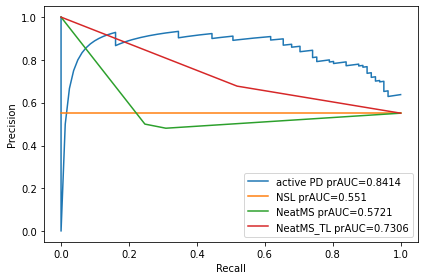

In [108]:
makePRCPlot(y_test_scores_active_syn[:,1],y_labeled[:,1],noSkill=True,label="active PD")
makePRCPlot(y_test_scores_neat_ms,y_labeled[:,1],noSkill=False,label="NeatMS")
makePRCPlot(y_test_scores_neat_ms_TL,y_labeled[:,1],noSkill=False,label="NeatMS_TL")

plt.tight_layout()
plt.savefig(datadir+"PRC_TL.png",dpi=300)

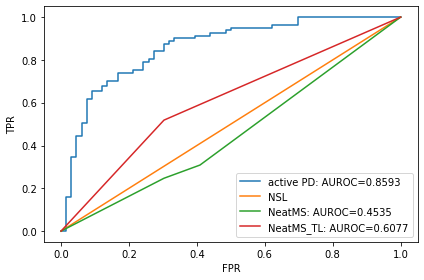

In [109]:
makeROCPlot(y_test_scores_active_syn[:,1],y_labeled[:,1],noSkill=True,label="active PD")
makeROCPlot(y_test_scores_neat_ms,y_labeled[:,1],noSkill=False,label="NeatMS")
makeROCPlot(y_test_scores_neat_ms_TL,y_labeled[:,1],noSkill=False,label="NeatMS_TL")

plt.tight_layout()
plt.savefig(datadir+"ROC_TL.png",dpi=300)

In [110]:
acc_results = {"active PD":{},"NeatMS":{},"NeatMS TL":{}}
for metricFunc,name in zip([met.accuracy_score,met.precision_score,met.recall_score],["accuracy","precision","recall"]):
    acc_results["active PD"][name] = metricFunc(y_labeled[:,1],y_test_scores_active_syn[:,1] > cutoff)
    acc_results["NeatMS"][name] = metricFunc(y_labeled[:,1],y_test_scores_neat_ms > 0.25)
    acc_results["NeatMS TL"][name] = metricFunc(y_labeled[:,1],y_test_scores_neat_ms_TL > 0.25)

acc_results = pd.DataFrame.from_dict(acc_results,orient="index")
acc_results.to_csv(datadir + "accuracy_results.csv")
acc_results

,accuracy,precision,recall
active PD,0.761905,0.802632,0.753086
NeatMS,0.435374,0.480769,0.308642
NeatMS TL,0.598639,0.677419,0.518519
